# Tabular Classification Benchmarks for SG-FIGS Evaluation

This notebook demonstrates the dataset generation pipeline for SG-FIGS (Synergy-Guided FIGS) evaluation benchmarks.

**What it does:** Converts tabular classification datasets into a standardized JSON schema where each row becomes a separate example with:
- JSON-serialized feature values as input
- Integer class label as output
- Metadata: 5-fold CV assignments, feature names, task type, domain, and dataset statistics

**Data source:** A curated subset of the Iris dataset (51 examples across 3 classes) from the full 10-dataset benchmark collection (5,061 examples total).

In [ ]:
%%capture
%pip install -q numpy==2.2.6 pandas==2.2.3 matplotlib==3.10.1

In [2]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

Load the mini demo dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-fb8249-synergy-guided-oblique-splits-using-part/main/dataset_iter1_tabular_bench/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")

Loaded 1 dataset(s)


## Configuration

Tunable parameters for the dataset processing pipeline.

In [5]:
# Number of cross-validation folds for fold assignment
N_FOLDS = 5

# Random seed for reproducible fold assignments
RANDOM_SEED = 42

# Maximum number of examples to process per dataset (None = all)
MAX_EXAMPLES_PER_DATASET = None

## NumpyEncoder

Custom JSON encoder to handle numpy types when serializing feature values.

In [6]:
class NumpyEncoder(json.JSONEncoder):
    """JSON encoder that handles numpy types."""
    def default(self, obj):
        if isinstance(obj, (np.integer,)):
            return int(obj)
        if isinstance(obj, (np.floating,)):
            return float(obj)
        if isinstance(obj, (np.bool_,)):
            return bool(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        return super().default(obj)

## Process Dataset

Convert the loaded JSON data into a structured format. Each example contains JSON-serialized feature values, a class label, and metadata including fold assignments for cross-validation.

In [7]:
def process_dataset(dataset_entry: dict) -> dict:
    """Process a single dataset entry from the loaded JSON data.

    Re-parses each example's input JSON string back into feature values,
    re-assigns fold labels, and returns a summary with processed examples.
    """
    snake_name = dataset_entry["dataset"]
    examples = dataset_entry["examples"]

    if MAX_EXAMPLES_PER_DATASET is not None:
        examples = examples[:MAX_EXAMPLES_PER_DATASET]

    # Extract metadata from the first example
    first = examples[0]
    feature_names = first["metadata_feature_names"]
    n_classes = first["metadata_n_classes"]
    domain = first["metadata_domain"]
    n_features = first["metadata_n_features"]

    # Re-assign fold labels for reproducibility
    n_samples = len(examples)
    rng = np.random.RandomState(RANDOM_SEED)
    fold_assignments = rng.randint(0, N_FOLDS, size=n_samples).tolist()

    processed = []
    for idx, ex in enumerate(examples):
        # Parse the input JSON string to extract feature values
        feature_dict = json.loads(ex["input"])

        # Rebuild the example with fresh fold assignment
        processed_example = {
            "input": json.dumps(feature_dict),
            "output": ex["output"],
            "metadata_fold": fold_assignments[idx],
            "metadata_feature_names": feature_names,
            "metadata_task_type": "classification",
            "metadata_n_classes": n_classes,
            "metadata_row_index": idx,
            "metadata_n_features": n_features,
            "metadata_domain": domain,
        }
        processed.append(processed_example)

    print(f"  {snake_name}: {len(processed)} examples, {n_features} features, {n_classes} classes")
    return {"dataset": snake_name, "examples": processed}


# Process all datasets
print("=" * 60)
print("Processing datasets from loaded JSON")
print("=" * 60)

datasets_output = []
total_examples = 0

for ds_entry in data["datasets"]:
    result = process_dataset(ds_entry)
    datasets_output.append(result)
    total_examples += len(result["examples"])

print(f"\nTotal: {len(datasets_output)} dataset(s), {total_examples} examples")

Processing datasets from loaded JSON
  iris: 51 examples, 4 features, 3 classes

Total: 1 dataset(s), 51 examples


## Inspect Example Structure

Examine a single processed example to see the JSON schema.

In [8]:
# Show the first example in detail
first_dataset = datasets_output[0]
first_example = first_dataset["examples"][0]

print(f"Dataset: {first_dataset['dataset']}")
print(f"\nExample structure:")
print(json.dumps(first_example, indent=2, cls=NumpyEncoder))

Dataset: iris

Example structure:
{
  "input": "{\"sepal length (cm)\": 5.1, \"sepal width (cm)\": 3.5, \"petal length (cm)\": 1.4, \"petal width (cm)\": 0.2}",
  "output": "0",
  "metadata_fold": 3,
  "metadata_feature_names": [
    "sepal length (cm)",
    "sepal width (cm)",
    "petal length (cm)",
    "petal width (cm)"
  ],
  "metadata_task_type": "classification",
  "metadata_n_classes": 3,
  "metadata_row_index": 0,
  "metadata_n_features": 4,
  "metadata_domain": "botany"
}


## Visualization

Analyze the processed dataset: class distribution, fold assignments, and feature value distributions.

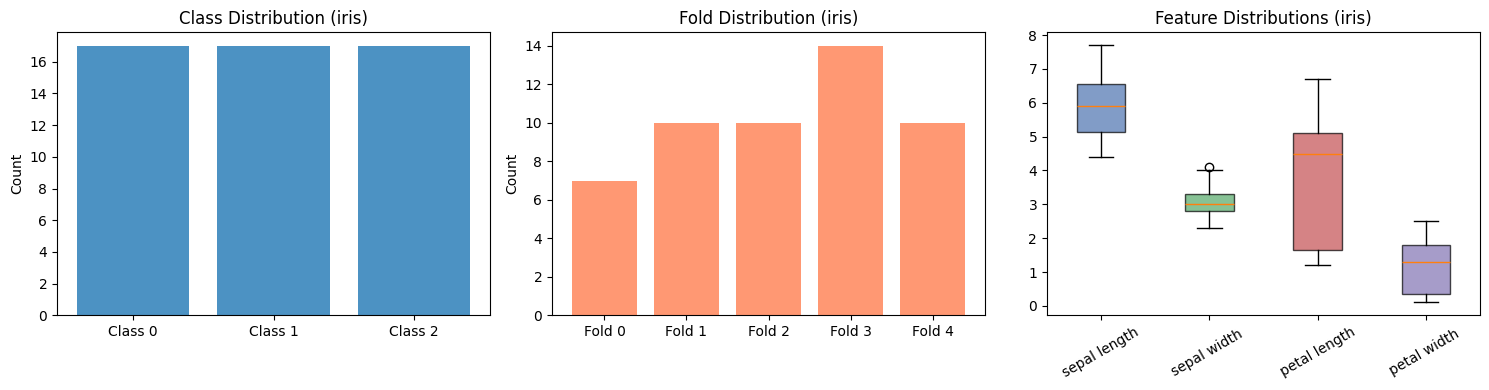


Dataset Summary
Dataset         Examples Features Classes Domain         
------------------------------------------------------------
iris                  51        4       3 botany         
------------------------------------------------------------
TOTAL                 51


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ds in datasets_output:
    examples = ds["examples"]
    ds_name = ds["dataset"]

    # --- Plot 1: Class distribution ---
    class_labels = [ex["output"] for ex in examples]
    unique, counts = np.unique(class_labels, return_counts=True)
    axes[0].bar([f"Class {u}" for u in unique], counts, alpha=0.8)
    axes[0].set_title(f"Class Distribution ({ds_name})")
    axes[0].set_ylabel("Count")

    # --- Plot 2: Fold assignment distribution ---
    folds = [ex["metadata_fold"] for ex in examples]
    fold_unique, fold_counts = np.unique(folds, return_counts=True)
    axes[1].bar([f"Fold {f}" for f in fold_unique], fold_counts, alpha=0.8, color="coral")
    axes[1].set_title(f"Fold Distribution ({ds_name})")
    axes[1].set_ylabel("Count")

    # --- Plot 3: Feature value distributions (first 4 features) ---
    feature_names = examples[0]["metadata_feature_names"]
    n_show = min(4, len(feature_names))
    feature_data = []
    for ex in examples:
        fdict = json.loads(ex["input"])
        feature_data.append([fdict[feature_names[i]] for i in range(n_show)])
    feature_data = np.array(feature_data)

    bp = axes[2].boxplot(
        [feature_data[:, i] for i in range(n_show)],
        tick_labels=[fn[:12] for fn in feature_names[:n_show]],
        patch_artist=True,
    )
    colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2"]
    for patch, color in zip(bp["boxes"], colors[:n_show]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[2].set_title(f"Feature Distributions ({ds_name})")
    axes[2].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

# --- Summary table ---
print("\n" + "=" * 60)
print("Dataset Summary")
print("=" * 60)
print(f"{'Dataset':<15} {'Examples':>8} {'Features':>8} {'Classes':>7} {'Domain':<15}")
print("-" * 60)
for ds in datasets_output:
    ex0 = ds["examples"][0]
    print(f"{ds['dataset']:<15} {len(ds['examples']):>8} {ex0['metadata_n_features']:>8} "
          f"{ex0['metadata_n_classes']:>7} {ex0['metadata_domain']:<15}")
print("-" * 60)
print(f"{'TOTAL':<15} {total_examples:>8}")